# Project: What's related to the show-up rate?
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Brazil. A number of characteristics about the patient are included in each row, including:

- Patient and Appointment Identification Information;
- Patients' Geographic Information: including gender, neighbourhood, past diseases, handcap, etc.;
- Notifications from the Clinic: SMS sending.

The problem to be explored over the course of the report are:
- What's the relationship between show-up rate and health-ralated geographic information?
- Are receiving SMS and days between schedule and appointment correlated to the probability of show-up?

Through this exploratory report, the insights drawn can be used to facilitate further analysis in predicting the showup for each appointment.

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from datetime import datetime

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [3]:
# Load and inspect the data

data = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


This dataframe contains 110527 rows of observations, with 14 columns.

Obviously, There are some transformations necessary for this dataset:

- Scheduled Day and Appointment Day: Need to be transformed into daytime format;
- Daybetween: In order to utilize the two columns mentioned above, we also need to calculate the dats between these two days;
- No-show to Show-up: It's more intuitive to record the values of show-ups instead of no-show;
- Finally, inspect the nullness of values.

### Data Cleaning

#### Transform Daytime columns

In [87]:
def datetime_transformation(string):
    exact_time = datetime.strptime(string,"%Y-%m-%dT%H:%M:%SZ")
    new_format = "%Y-%m-%d"
    return(exact_time)

In [96]:
data_trans = data.copy()
data_trans['ScheduledDay'] = data['ScheduledDay'].apply(datetime_transformation).dt.date
data_trans['AppointmentDay'] = data['AppointmentDay'].apply(datetime_transformation).dt.date

Create a new column with the days between ScheduledDay and AppointmentDay

In [106]:
data_trans['Daysbetween'] = abs(data_trans['AppointmentDay'] - data_trans['ScheduledDay']).dt.days

#### No-show to Show-up

In [99]:
data_trans['show_up'] = data_trans['No-show'].apply(lambda x: 'Yes' if x == 'No' else 'No')

#### Fill/Drop the NA values

In [100]:
data_trans[data_trans.isnull().any(axis=1)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Daysbetween,show_up


There's no empty value unfilled in the dataset. The dataset is clean by now.

__View the new dataset__

In [101]:
data_trans.sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Daysbetween,show_up
76228,5.246285e+12,5661009,M,2016-05-05,2016-05-05,1,CARATOÍRA,0,0,0,0,0,0,No,0 days,Yes
44898,4.567163e+13,5696386,F,2016-05-13,2016-05-13,27,TABUAZEIRO,0,0,0,0,0,0,No,0 days,Yes
22399,5.649747e+14,5672795,M,2016-05-09,2016-05-10,13,RESISTÊNCIA,0,0,0,0,0,0,No,1 days,Yes
38528,1.762653e+11,5612235,F,2016-04-25,2016-05-30,2,MARIA ORTIZ,0,0,0,0,0,1,No,35 days,Yes
21645,1.288798e+13,5737096,F,2016-05-25,2016-05-25,37,MARUÍPE,0,0,0,0,1,0,No,0 days,Yes


<a id='eda'></a>
## Exploratory Data Analysis

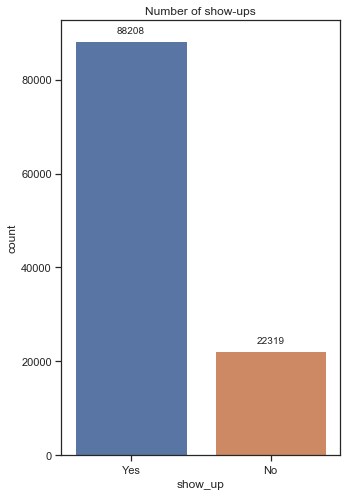

In [158]:
plt.figure(figsize=(5, 8))
plt.title('Number of show-ups')
countplot = sns.countplot(x="show_up", data=data_trans)
for p in countplot.patches:
    countplot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


On average, the ratio of show-up and no-show-up is 4:1, which means the show-up rate is nearly 80%.

### What's the relationship between show-up rate and health-ralated geographic information?

In [175]:
disease = ['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']

In [247]:
def draw_the_prop(num):
    plt.figure(figsize = (4,8))
    x, y, hue = ['show_up', 'prop', disease[num]]

    prop_df = (data_trans[x]
            .groupby(data_trans[hue])
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

    bar = sns.barplot(x = x, y = y, hue=hue, data = prop_df[prop_df['show_up'] == 'Yes'])
    for p in bar.patches:
        bar.annotate(format(p.get_height(),'.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.legend(loc='lower right', title = hue)
    plt.title('Show up rate against ' + disease[num])

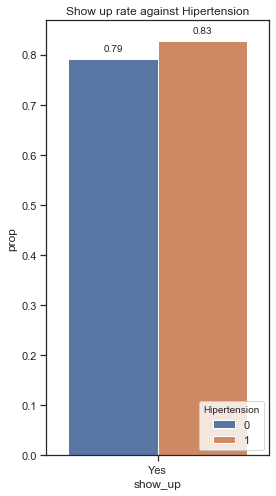

In [248]:
draw_the_prop(0)

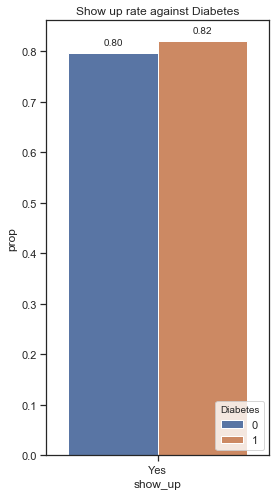

In [249]:
draw_the_prop(1)

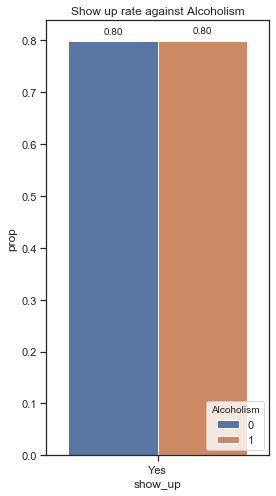

In [250]:
draw_the_prop(2)

The difference in showup rates for people who have or have not Hipertension, Diabetes and Alcoholism is not drastic. The average proportion of showup rates are all around 0.8.

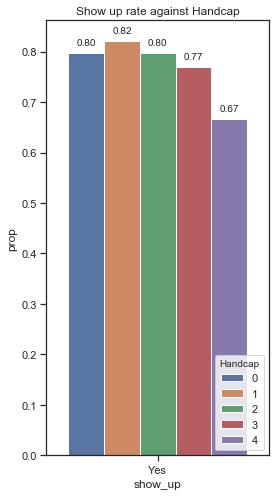

In [256]:
draw_the_prop(3)

The showup rate for 0-2 Handcap level people are still around 0.8. 
However, for people with 4 and 5 level Handcap, they tend to have lower showup rate. And higher the Handcap level, the lower the showup rate.

### Is the probability of show-up correlated to receiving SMS and days between schedule and appointment?

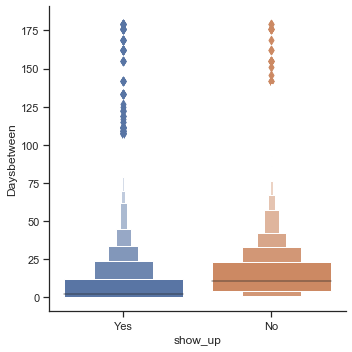

In [253]:
sns.catplot(x="show_up", y="Daysbetween", kind = 'boxen', data=data_trans)

Vividly as the plot shows, people who showed up have fewer days between schedule day and appointment day.

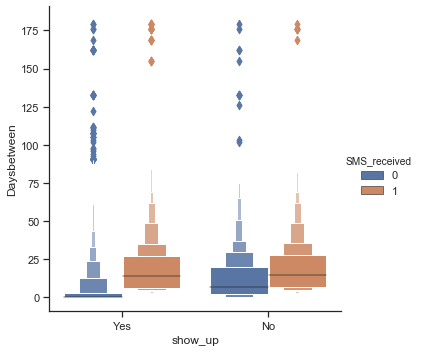

In [255]:
sns.catplot(x="show_up", y="Daysbetween", hue = 'SMS_received', kind = 'boxen', data=data_trans)

For people who don't receive SMS, the relationship between showup rate and Daysbetween remains in the above plot, as the gap between scheduled day and appointment day for people who don't show up is longer. However, we can see that receiving a SMS will raise the average Daybetween drastically for people to nearly 20. 

<a id='conclusions'></a>
## Conclusions

From the visualizations above, we can draw two pieces of important conclusion:

- The show-up rate is partially related to Health-ralated geographic information, especially the level of handcap. For people with 4 and 5 level Handcap, they tend to have lower showup rate. And higher the Handcap level, the lower the showup rate.

- Generally, people who showed up have fewer days between schedule day and appointment day. But for people who received SMS, the average gap between schedule day and appointment day is expanded. This might suggest an interaction effect between receiving SMS and Days between scheduled data and appointment date.